In [53]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass
#from google.colab import drive
#drive.mount('/content/drive')

In [54]:
df1 = pd.read_csv('LeleInputForecast.csv', sep =',')

In [55]:
Q1 = df1['Harga'].quantile(0.25)
Q3 = df1['Harga'].quantile(0.75)
IQR = Q3 - Q1
# df = df1[(df1['Harga'] >= Q1 - 1.5 * IQR) & (df1['Harga'] <= Q3 + 1.5 * IQR)]
threshold = 1.5*IQR
median = np.median(df1['Harga'])
outliers = (df1['Harga'] < Q1 - threshold) | (df1['Harga'] > Q3 + threshold)
df1[outliers] = median

In [56]:
# def get_data(filename):
    
#     times = []
#     value = []

#     with open(filename) as csvfile:
        
#         reader = csv.reader(csvfile, delimiter=',')
#         next(reader)
#         i = 0
#         for row in reader:
#             times.append(i)
#             value.append(float(row[1])/1000)
#             i+=1

    
#     return times, value



def get_data(data):
    
    times = []
    value = []

    i = 0
    for row in data:
      times.append(i)
      value.append(float(row)/1000)
      i+=1

    
    return times, value





In [57]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [58]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    FILE_CSV = 'LeleInputForecast.csv'
    times, price = get_data(df1['Harga'])
    TIME = np.array(times)
    SERIES = np.array(price)
    SPLIT_TIME = 90
    WINDOW_SIZE = 12
    BATCH_SIZE = 12
    SHUFFLE_BUFFER_SIZE = 10


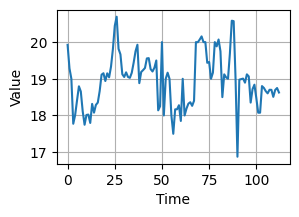

In [59]:
plt.figure(figsize=(3, 2))
plot_series(G.TIME, G.SERIES)
plt.show()

In [60]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

In [61]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [62]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [63]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Build the Model

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [64]:
def create_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[G.WINDOW_SIZE, 1]),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), #ganti 64
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100)
    ]) 

    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 32)            128       
                                                                 
 bidirectional (Bidirectiona  (None, 12, 64)           16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [65]:
# Test your uncompiled model
uncompiled_model = create_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

7/7 [==============================] - 2s 12ms/step
Your current architecture is compatible with the windowed dataset! :)


In [66]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
7/7 [==============================] - 10s 29ms/step - loss: 20.5503 - lr: 1.0000e-08
Epoch 2/100
7/7 [==============================] - 0s 28ms/step - loss: 20.5125 - lr: 1.1220e-08
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 20.4501 - lr: 1.2589e-08
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 20.3706 - lr: 1.4125e-08
Epoch 5/100
7/7 [==============================] - 0s 25ms/step - loss: 20.2769 - lr: 1.5849e-08
Epoch 6/100
7/7 [==============================] - 0s 31ms/step - loss: 20.1699 - lr: 1.7783e-08
Epoch 7/100
7/7 [==============================] - 0s 27ms/step - loss: 20.0491 - lr: 1.9953e-08
Epoch 8/100
7/7 [==============================] - 0s 28ms/step - loss: 19.9134 - lr: 2.2387e-08
Epoch 9/100
7/7 [==============================] - 0s 26ms/step - loss: 19.7612 - lr: 2.5119e-08
Epoch 10/100
7/7 [==============================] - 0s 25ms/step - loss: 19.5908 - lr: 2.8184e-08
Epoch 11/100
7/7 [==========

(1e-08, 0.001, 0.0, 50.0)

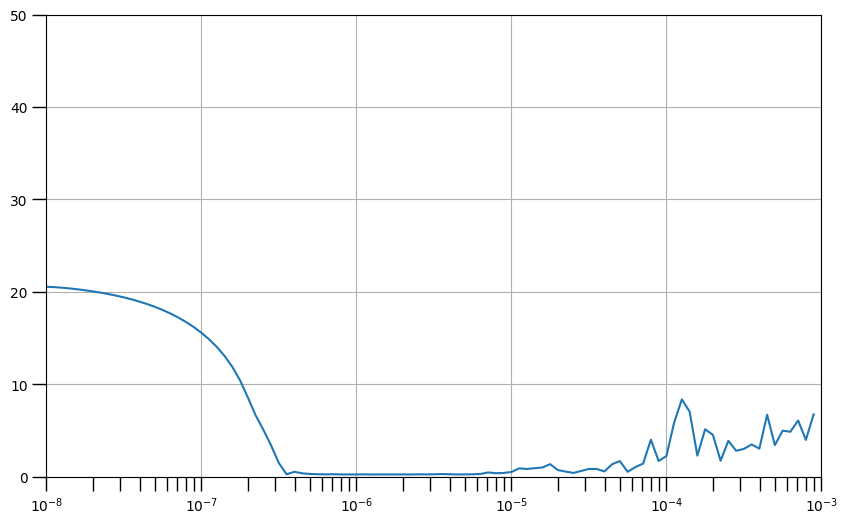

In [67]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [68]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [69]:
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [70]:
# Train the model
Epochs = 100
history = model.fit(train_set,epochs=Epochs)

Epoch 1/100
7/7 [==============================] - 11s 30ms/step - loss: 19.8892 - mae: 20.3892
Epoch 2/100
7/7 [==============================] - 0s 24ms/step - loss: 16.2672 - mae: 16.7672
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 10.2523 - mae: 10.7523
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 2.7915 - mae: 3.2839
Epoch 5/100
7/7 [==============================] - 0s 25ms/step - loss: 1.6714 - mae: 2.1518
Epoch 6/100
7/7 [==============================] - 0s 26ms/step - loss: 1.6017 - mae: 2.0811
Epoch 7/100
7/7 [==============================] - 0s 25ms/step - loss: 0.5359 - mae: 0.9322
Epoch 8/100
7/7 [==============================] - 0s 24ms/step - loss: 0.4070 - mae: 0.7987
Epoch 9/100
7/7 [==============================] - 0s 28ms/step - loss: 0.4047 - mae: 0.7903
Epoch 10/100
7/7 [==============================] - 0s 34ms/step - loss: 0.2886 - mae: 0.6248
Epoch 11/100
7/7 [==============================] - 0s 45ms/st

In [71]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [72]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [73]:
cnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
cnn_forecast = cnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
mse, mae = compute_metrics(series_valid, cnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

9/9 [==============================] - 3s 13ms/step
mse: 0.47, mae: 0.48 for forecast


9/9 [==============================] - 0s 14ms/step


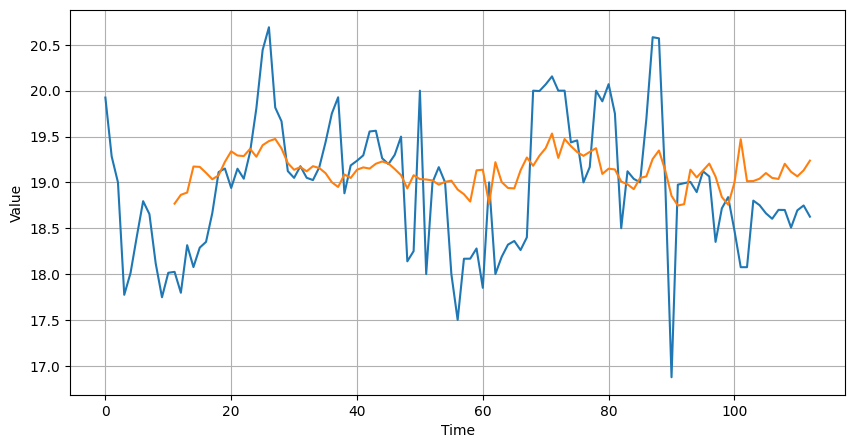

In [74]:
# Compute the forecast for all the series
cnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
tam = [None,None,None,None,None,None,None,None,None,None,None]


# Slice the forecast to get only the predictions for the validation set
# cnn_forecast = cnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
cnn_forecast = np.insert(cnn_forecast, 0, tam)

# Plot the forecast
plt.figure(figsize=(10, 5))
plot_series(G.TIME, G.SERIES)
plot_series(G.TIME, cnn_forecast)

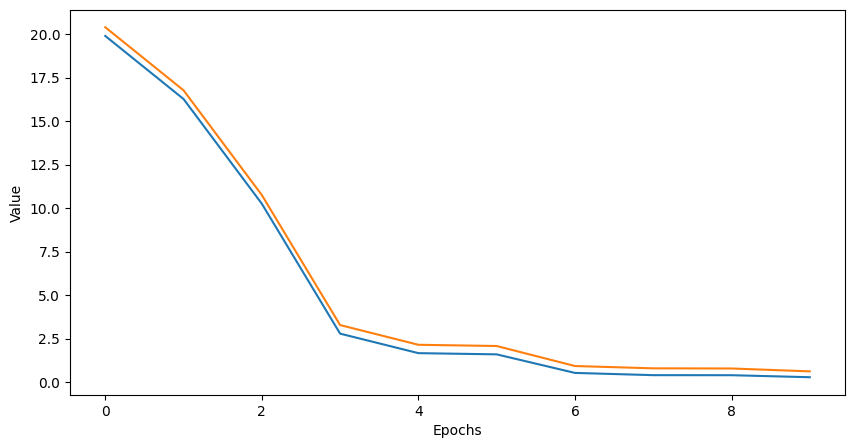

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(range(10), history.history["loss"][:10])
plt.plot(range(10), history.history["mae"][:10])
plt.xlabel("Epochs")
plt.ylabel("Value")

plt.show()

In [76]:
# prepare data for forecasting
last_window = G.SERIES[-G.WINDOW_SIZE:]
last_window = np.reshape(last_window, (1, G.WINDOW_SIZE, 1))

# make a forecast for n steps ahead
forecast_norm = []
for _ in range(3):
    pred = model.predict(last_window)[0, 0]
    forecast_norm.append(pred)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred

# invert the normalization
forecast = forecast_norm
print("Forecast:", forecast)

1/1 [==============================] - 0s 29ms/step
Forecast: [19.237019, 19.286457, 19.161919]


In [77]:
model.save("LelewithForecastedData90.h5")